In [1]:
import numpy as np
import pandas as pd
from io import StringIO
from pathlib import Path
from urllib.request import urlopen

# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

## Read files from Harvard Dataverse

In [2]:
url = "https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/WMGPGZ/HY6N2S"
file = urlopen(url).readlines()

## Clean datasets

### Step 1: Fix dataset corruption, incorrect line break, incorrect quotation mark

In [3]:
for i in range(len(file)):
    file[i] = file[i].decode("utf-8").lstrip('"').rstrip(';\r\n')
for i in [84,86,342,370,433,435,436,457,609,628,696,799,947,957,1030,1134,1534,1537,1938]:
    file[i] = file[i].replace('."', '."",""') + file[i+1].lstrip(',')
    del file[i+1]
for i in range(len(file)):
    file[i] = file[i][:-1]
for i in range(1, len(file)):
    file[i] = file[i].replace('""""', '"')
for i in range(1,4):
    file[i] = file[i].replace("\xa0", "")

In [4]:
# create a sep sign "",""
file[0] = '""' + file[0].rstrip('""')
for i in range(1, 10):
    file[i] = file[i][:1] + '""' + file[i][1:-5] + '""' + file[i][-5:-4] + '""' + file[i][-4:-3] + '""' +\
              file[i][-3:-2] + '""' + file[i][-2:-1] + '""' + file[i][-1:]
for i in range(10, 100):
    file[i] = file[i][:2] + '""' + file[i][2:-5] + '""' + file[i][-5:-4] + '""' + file[i][-4:-3] + '""' +\
              file[i][-3:-2] + '""' + file[i][-2:-1] + '""' + file[i][-1:]
for i in range(100, 1000):
    file[i] = file[i][:3] + '""' + file[i][3:-5] + '""' + file[i][-5:-4] + '""' + file[i][-4:-3] + '""' +\
              file[i][-3:-2] + '""' + file[i][-2:-1] + '""' + file[i][-1:]
for i in range(1000, len(file)):
    file[i] = file[i][:4] + '""' + file[i][4:-5] + '""' + file[i][-5:-4] + '""' + file[i][-4:-3] + '""' +\
              file[i][-3:-2] + '""' + file[i][-2:-1] + '""' + file[i][-1:]

In [5]:
# read the repaired dataframe
df_all = pd.read_csv(StringIO('\n'.join(file)), sep='"",""', engine='python')
df_all = df_all.drop(["Unnamed: 0", "inclusion_code"], axis=1)

### Step 2: Add `record_id`,  `label_included` & `label_abstract_screening`

In [6]:
# add record_id
df_all.insert(0, "record_id", df_all.index + 1)

In [7]:
# add labels
df_all.rename(columns={"included": "label_included", "abstract_included": "label_abstract_screening"}, inplace=True)

### Step 3: Find duplicate records and add `duplicate_record_id`

In [8]:
# find duplicates based on title and authors
df_all.sort_values(["label_included", "label_abstract_screening"], ascending=False, inplace=True)
df_all = df_all.assign(title_clean=df_all["title"].str.replace("[^A-Za-z0-9]", "", regex=True).str.lower())
duplicate = df_all.duplicated(subset=["title_clean"])
df_all["duplicate_record_id"] = np.where(duplicate, 1, np.nan)

In [9]:
# if duplicate, duplicate_id indicates the corresponding record_id, otherwise NA
for i in range(len(df_all)):
    if df_all.loc[i, "duplicate_record_id"] == 1:
        df_all.loc[i, "duplicate_record_id"] = df_all.loc[~duplicate & df_all.loc[~duplicate, "title_clean"].isin([df_all.loc[i, "title_clean"]]), "record_id"].tolist()
df_all.duplicate_record_id = df_all.duplicate_record_id.astype("Int64")

### Step 4: Sort by orginal order and retain useful columns

In [10]:
df_all.sort_values("record_id", inplace=True)
df_all = df_all[["record_id", "title", "abstract", "label_included", "label_abstract_screening", "duplicate_record_id"]]

## Export datasets

In [11]:
Path("output").mkdir(parents=True, exist_ok=True)
df_all.to_csv("output/Nagtegaal_2019.csv", index=False)

## Dataset statistics

### Summary of inclusions and exclusions

In [12]:
n = len(df_all)
n_dup = (~df_all["duplicate_record_id"].isna()).sum()
n_wo_dup = n - n_dup
n_inc = df_all.loc[df_all.duplicate_record_id.isna(), "label_included"].sum()
n_inc_abs = df_all.loc[df_all.duplicate_record_id.isna(), "label_abstract_screening"].sum()
n_exc = n_wo_dup - n_inc
n_exc_abs = n_wo_dup - n_inc_abs
n_exc_full = n_inc_abs - n_inc

print("Total number of papers:                     ", n, "(includes", n_dup, "duplicates) \n")
print("Total number of papers without duplicates:  ", n_wo_dup, "\n\n")
print("Following statistics calculated without duplicates: \n")
print("Total number of EXCLUSIONS:                 ", n_exc, "\n")
print("Total EXCLUSIONS after abstract screening:  ", n_exc_abs, "\n")
print("Total INCLUSIONS after abstract screening:  ", n_inc_abs, "\n")
print("Total EXCLUSIONS after full text screening: ", n_exc_full, "\n")
print("Total INCLUSIONS after full text screening: ", n_inc, " (", round(100*n_inc/n, 2), "% )\n")

Total number of papers:                      2019 (includes 11 duplicates) 

Total number of papers without duplicates:   2008 


Following statistics calculated without duplicates: 

Total number of EXCLUSIONS:                  1907 

Total EXCLUSIONS after abstract screening:   1619 

Total INCLUSIONS after abstract screening:   389 

Total EXCLUSIONS after full text screening:  288 

Total INCLUSIONS after full text screening:  101  ( 5.0 % )



### Missingness of title and abstract

In [13]:
print("Number of papers with missing title:              ", df_all["title"].isna().sum(), "\n")
print("Number of papers with missing abstract:           ", df_all["abstract"].isna().sum(), "\n")

Number of papers with missing title:               0 

Number of papers with missing abstract:            169 



### Word cloud for titles and abstracts

There are 213282 words in the combination of all titles. 

There are 3397312 words in the combination of all abstracts. 



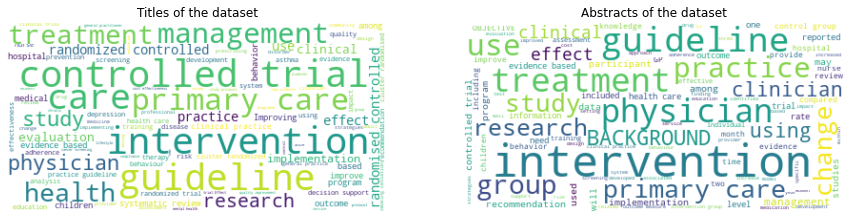

In [14]:
# create stopword list
stopwords = set(STOPWORDS)
stopwords.update(["patient", "patients", "method", "methods", "result", "results", "conclusion", "conclusions"])

# create word cloud text
title_text = " ".join(word for word in df_all.title.dropna())
abstract_text = " ".join(word for word in df_all.abstract.dropna())
print("There are {} words in the combination of all titles.".format(len(title_text)), "\n")
print("There are {} words in the combination of all abstracts.".format(len(abstract_text)), "\n")

# generate word cloud images
title_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(title_text)
abstract_wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(abstract_text)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[15, 15])
ax1.imshow(title_wordcloud, interpolation="bilinear")
ax1.set_title("Titles of the dataset")
ax1.axis("off")
ax2.imshow(abstract_wordcloud, interpolation="bilinear")
ax2.set_title("Abstracts of the dataset")
ax2.axis("off")
plt.show()